## This notebook aims to visualize the different asset distributions produced by CGAN

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../"))
sys.path.insert(0, parent_dir)

from utilities.gan_plotting import extensive_plotting
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical

from dotenv.main import load_dotenv
load_dotenv(override=True)
import os


In [2]:
import os
print(os.getcwd())

c:\Users\nicka\master-thesis\internal_models\GANs\tuned_GANS


### Parameters

In [3]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
num_simulations = int(os.getenv("N_SIMULATIONS"))
bof_0 = assets_0 - liabilities_0

## Note to self -- We only test assets MSCIWORLD, HY and EONIA

In [4]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [0, 1, 2, 3, 4, 5, 6]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [5]:
asset_names = returns_df.columns

num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

## TRAINING CGAN

In [6]:
from astrid_GAN import AstridGAN
from nova_GAN import NovaGAN

gan_dict = {}

# Dictionary to store generated scenarios by asset and date.
# Structure: { asset_name: { date: generated_scenarios, ... }, ... }
scenarios_results = {}

for asset_name in tqdm(returns_df.columns, desc="Training GANs", unit="asset"):
    print(f"Training GAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    
    gan = NovaGAN(asset_returns, asset_name)
    gan.train()
    print(f"Finished training GAN for {asset_name}.\n")
    
    scenarios = gan.generate_scenarios(num_scenarios=10000)
    print(f"Finished generating scenarios for {asset_name}.\n")
    
    gan_dict[asset_name] = gan

    initial_date = returns_df.index[-1]
    scenarios_results.setdefault(asset_name, {})[initial_date] = scenarios
    print(f"{asset_name}: Stored initial generated scenarios for {initial_date}.")

# Online training during the test period
# Assume test_returns_df contains daily returns for the test period
'''
for test_day in test_returns_df.index:
    for asset_name in test_returns_df.columns:
        new_return = test_returns_df.loc[test_day, asset_name]
        gan = gan_dict[asset_name]
        
        # Process the new return (online_training handles fine-tuning or full retraining as needed)
        print("date", test_day)
        gan.online_training(new_return)
        print(f"{asset_name}: Processed online update for new return on {test_day}.")
        
        # Generate scenarios with the updated GAN
        scenarios = gan.generate_scenarios(save=False, num_scenarios=10000)
        
        # Store the generated scenarios for this test day
        scenarios_results.setdefault(asset_name, {})[test_day] = scenarios
        print(f"{asset_name}: Stored generated scenarios for {test_day}.")'
'''

# At this point, scenarios_results contains the generated scenario distribution for each asset keyed by date.

for asset_name in tqdm(test_returns_df.columns, desc="Updating GANs", unit="asset"):
    asset_returns = returns_df[asset_name]
    
    for test_day in test_returns_df.index:
        new_return = test_returns_df.loc[test_day, asset_name]
        new_row = pd.DataFrame({asset_name: [new_return]}, index=[test_day])
        asset_returns = pd.concat([asset_returns, new_row])
        
        gan = NovaGAN(asset_returns, asset_name)
        
        # You might want to add a print statement inside the GAN training loop
        # to check the batch size, for example, in the beginning of gan.train():
        gan.train()
        
        print(f"{asset_name}: Processed online update for new return on {test_day}.")
        
        scenarios = gan.generate_scenarios(save=False, num_scenarios=10000)
        scenarios_results.setdefault(asset_name, {})[test_day] = scenarios
        
        print(f"{asset_name}: Stored generated scenarios for {test_day}.")


Training GANs:   0%|          | 0/7 [00:00<?, ?asset/s]

Training GAN for REEL...
[Epoch 0/2] [Batch 0/15] [D loss: -0.1122] [G loss: 0.2750]
[Epoch 0/2] [Batch 10/15] [D loss: -0.0538] [G loss: -0.0004]
[Epoch 1/2] [Batch 0/15] [D loss: -0.1238] [G loss: 0.1902]


Training GANs:  14%|█▍        | 1/7 [00:02<00:16,  2.77s/asset]

[Epoch 1/2] [Batch 10/15] [D loss: -0.0111] [G loss: 0.2526]
Finished training GAN for REEL.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_REEL_final_scenarios.pt
Finished generating scenarios for REEL.

REEL: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for PE...
[Epoch 0/2] [Batch 0/15] [D loss: 0.0071] [G loss: -0.0201]
[Epoch 0/2] [Batch 10/15] [D loss: -0.0587] [G loss: 0.0205]
[Epoch 1/2] [Batch 0/15] [D loss: -0.0497] [G loss: 0.1208]


Training GANs:  29%|██▊       | 2/7 [00:04<00:09,  1.89s/asset]

[Epoch 1/2] [Batch 10/15] [D loss: -0.1950] [G loss: 0.0973]
Finished training GAN for PE.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt
Finished generating scenarios for PE.

PE: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for MSCIWORLD...
[Epoch 0/2] [Batch 0/15] [D loss: -0.0524] [G loss: -0.1264]
[Epoch 0/2] [Batch 10/15] [D loss: 0.1720] [G loss: -0.0449]
[Epoch 1/2] [Batch 0/15] [D loss: -0.0667] [G loss: 0.0955]


Training GANs:  43%|████▎     | 3/7 [00:05<00:06,  1.60s/asset]

[Epoch 1/2] [Batch 10/15] [D loss: -0.0967] [G loss: 0.0507]
Finished training GAN for MSCIWORLD.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_MSCIWORLD_final_scenarios.pt
Finished generating scenarios for MSCIWORLD.

MSCIWORLD: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for IG...
[Epoch 0/2] [Batch 0/15] [D loss: 0.0654] [G loss: 0.0270]
[Epoch 0/2] [Batch 10/15] [D loss: 0.2014] [G loss: 0.0993]
[Epoch 1/2] [Batch 0/15] [D loss: 0.0223] [G loss: 0.0236]


Training GANs:  57%|█████▋    | 4/7 [00:06<00:04,  1.48s/asset]

[Epoch 1/2] [Batch 10/15] [D loss: 0.0352] [G loss: 0.0042]
Finished training GAN for IG.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt
Finished generating scenarios for IG.

IG: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for GOV...
[Epoch 0/2] [Batch 0/15] [D loss: -0.0715] [G loss: 0.1050]
[Epoch 0/2] [Batch 10/15] [D loss: -0.1397] [G loss: -0.1249]
[Epoch 1/2] [Batch 0/15] [D loss: -0.1432] [G loss: 0.1157]


Training GANs:  71%|███████▏  | 5/7 [00:07<00:02,  1.41s/asset]

[Epoch 1/2] [Batch 10/15] [D loss: 0.0756] [G loss: -0.0562]
Finished training GAN for GOV.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_GOV_final_scenarios.pt
Finished generating scenarios for GOV.

GOV: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for HY...
[Epoch 0/2] [Batch 0/15] [D loss: -0.1941] [G loss: 0.3358]
[Epoch 0/2] [Batch 10/15] [D loss: -0.1616] [G loss: 0.3166]
[Epoch 1/2] [Batch 0/15] [D loss: -0.2053] [G loss: 0.4337]


Training GANs:  86%|████████▌ | 6/7 [00:09<00:01,  1.36s/asset]

[Epoch 1/2] [Batch 10/15] [D loss: 0.0083] [G loss: 0.4422]
Finished training GAN for HY.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_HY_final_scenarios.pt
Finished generating scenarios for HY.

HY: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for EONIA...
[Epoch 0/2] [Batch 0/15] [D loss: 0.0316] [G loss: -0.0345]
[Epoch 0/2] [Batch 10/15] [D loss: -0.1227] [G loss: -0.0293]
[Epoch 1/2] [Batch 0/15] [D loss: -0.1158] [G loss: 0.1604]


Training GANs: 100%|██████████| 7/7 [00:10<00:00,  1.48s/asset]


[Epoch 1/2] [Batch 10/15] [D loss: 0.2031] [G loss: 0.1202]
Finished training GAN for EONIA.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
Finished generating scenarios for EONIA.

EONIA: Stored initial generated scenarios for 2019-12-31 00:00:00.


Updating GANs:   0%|          | 0/7 [00:00<?, ?asset/s]

[Epoch 0/2] [Batch 0/15] [D loss: 0.0271] [G loss: 0.1977]
[Epoch 0/2] [Batch 10/15] [D loss: 0.0263] [G loss: 0.1704]
[Epoch 1/2] [Batch 0/15] [D loss: -0.1703] [G loss: 0.0901]
[Epoch 1/2] [Batch 10/15] [D loss: -0.1895] [G loss: 0.0229]
REEL: Processed online update for new return on 2020-01-02 00:00:00.
REEL: Stored generated scenarios for 2020-01-02 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: 0.1428] [G loss: -0.1049]
[Epoch 0/2] [Batch 10/15] [D loss: 0.1095] [G loss: -0.1274]
[Epoch 1/2] [Batch 0/15] [D loss: -0.0018] [G loss: -0.1069]
[Epoch 1/2] [Batch 10/15] [D loss: -0.1343] [G loss: -0.1858]
REEL: Processed online update for new return on 2020-01-03 00:00:00.
REEL: Stored generated scenarios for 2020-01-03 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: 0.1180] [G loss: -0.0988]
[Epoch 0/2] [Batch 10/15] [D loss: -0.1549] [G loss: -0.2371]
[Epoch 1/2] [Batch 0/15] [D loss: 0.0085] [G loss: -0.1257]
[Epoch 1/2] [Batch 10/15] [D loss: -0.0735] [G loss: -0.1076]
REEL: Processed on

Updating GANs:  14%|█▍        | 1/7 [05:34<33:28, 334.75s/asset]

[Epoch 1/2] [Batch 10/16] [D loss: 0.1287] [G loss: 0.2868]
REEL: Processed online update for new return on 2020-12-28 00:00:00.
REEL: Stored generated scenarios for 2020-12-28 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: -0.0433] [G loss: 0.1525]
[Epoch 0/2] [Batch 10/15] [D loss: 0.1807] [G loss: 0.1457]
[Epoch 1/2] [Batch 0/15] [D loss: -0.0192] [G loss: 0.1130]
[Epoch 1/2] [Batch 10/15] [D loss: 0.0674] [G loss: 0.2583]
PE: Processed online update for new return on 2020-01-02 00:00:00.
PE: Stored generated scenarios for 2020-01-02 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: -0.0251] [G loss: -0.0989]
[Epoch 0/2] [Batch 10/15] [D loss: -0.0097] [G loss: -0.2917]
[Epoch 1/2] [Batch 0/15] [D loss: 0.1288] [G loss: -0.0210]
[Epoch 1/2] [Batch 10/15] [D loss: 0.0535] [G loss: -0.1442]
PE: Processed online update for new return on 2020-01-03 00:00:00.
PE: Stored generated scenarios for 2020-01-03 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: -0.1586] [G loss: 0.0422]
[Epoch 0/2] [Batch 10/1

Updating GANs:  29%|██▊       | 2/7 [11:15<28:11, 338.23s/asset]

PE: Stored generated scenarios for 2020-12-28 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: 0.0189] [G loss: -0.0230]
[Epoch 0/2] [Batch 10/15] [D loss: -0.1013] [G loss: -0.0136]
[Epoch 1/2] [Batch 0/15] [D loss: -0.0140] [G loss: 0.2779]
[Epoch 1/2] [Batch 10/15] [D loss: -0.1071] [G loss: 0.0642]
MSCIWORLD: Processed online update for new return on 2020-01-02 00:00:00.
MSCIWORLD: Stored generated scenarios for 2020-01-02 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: -0.0811] [G loss: 0.0715]
[Epoch 0/2] [Batch 10/15] [D loss: -0.1423] [G loss: -0.1320]
[Epoch 1/2] [Batch 0/15] [D loss: 0.0133] [G loss: 0.0787]
[Epoch 1/2] [Batch 10/15] [D loss: -0.1861] [G loss: 0.0791]
MSCIWORLD: Processed online update for new return on 2020-01-03 00:00:00.
MSCIWORLD: Stored generated scenarios for 2020-01-03 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: -0.2429] [G loss: -0.1391]
[Epoch 0/2] [Batch 10/15] [D loss: 0.0309] [G loss: 0.0072]
[Epoch 1/2] [Batch 0/15] [D loss: -0.1046] [G loss: 0.0525]
[Epo

Updating GANs:  43%|████▎     | 3/7 [16:54<22:34, 338.60s/asset]

MSCIWORLD: Stored generated scenarios for 2020-12-28 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: 0.1286] [G loss: 0.0919]
[Epoch 0/2] [Batch 10/15] [D loss: 0.2596] [G loss: 0.0660]
[Epoch 1/2] [Batch 0/15] [D loss: -0.0523] [G loss: 0.0102]
[Epoch 1/2] [Batch 10/15] [D loss: -0.1129] [G loss: 0.2030]
IG: Processed online update for new return on 2020-01-02 00:00:00.
IG: Stored generated scenarios for 2020-01-02 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: -0.0301] [G loss: 0.1041]
[Epoch 0/2] [Batch 10/15] [D loss: 0.0899] [G loss: 0.2052]
[Epoch 1/2] [Batch 0/15] [D loss: -0.0751] [G loss: 0.0791]
[Epoch 1/2] [Batch 10/15] [D loss: -0.1117] [G loss: 0.0462]
IG: Processed online update for new return on 2020-01-03 00:00:00.
IG: Stored generated scenarios for 2020-01-03 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: -0.0910] [G loss: 0.1586]
[Epoch 0/2] [Batch 10/15] [D loss: 0.0448] [G loss: 0.1030]
[Epoch 1/2] [Batch 0/15] [D loss: -0.1728] [G loss: 0.0586]
[Epoch 1/2] [Batch 10/15] [D l

Updating GANs:  57%|█████▋    | 4/7 [22:38<17:02, 340.69s/asset]

IG: Stored generated scenarios for 2020-12-28 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: -0.0512] [G loss: -0.0877]
[Epoch 0/2] [Batch 10/15] [D loss: -0.0900] [G loss: -0.2907]
[Epoch 1/2] [Batch 0/15] [D loss: -0.0200] [G loss: -0.4570]
[Epoch 1/2] [Batch 10/15] [D loss: 0.0749] [G loss: -0.2249]
GOV: Processed online update for new return on 2020-01-02 00:00:00.
GOV: Stored generated scenarios for 2020-01-02 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: -0.0750] [G loss: -0.1392]
[Epoch 0/2] [Batch 10/15] [D loss: -0.1152] [G loss: -0.0956]
[Epoch 1/2] [Batch 0/15] [D loss: -0.1381] [G loss: -0.0796]
[Epoch 1/2] [Batch 10/15] [D loss: 0.1145] [G loss: 0.0101]
GOV: Processed online update for new return on 2020-01-03 00:00:00.
GOV: Stored generated scenarios for 2020-01-03 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: -0.0174] [G loss: 0.1898]
[Epoch 0/2] [Batch 10/15] [D loss: -0.1994] [G loss: 0.0619]
[Epoch 1/2] [Batch 0/15] [D loss: 0.0074] [G loss: 0.2660]
[Epoch 1/2] [Batch 10/15]

Updating GANs:  71%|███████▏  | 5/7 [28:22<11:23, 341.91s/asset]

GOV: Stored generated scenarios for 2020-12-28 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: -0.0142] [G loss: 0.4129]
[Epoch 0/2] [Batch 10/15] [D loss: -0.0642] [G loss: 0.2550]
[Epoch 1/2] [Batch 0/15] [D loss: -0.1405] [G loss: 0.3239]
[Epoch 1/2] [Batch 10/15] [D loss: -0.0767] [G loss: 0.4413]
HY: Processed online update for new return on 2020-01-02 00:00:00.
HY: Stored generated scenarios for 2020-01-02 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: 0.0889] [G loss: -0.2296]
[Epoch 0/2] [Batch 10/15] [D loss: 0.0100] [G loss: -0.1861]
[Epoch 1/2] [Batch 0/15] [D loss: 0.1637] [G loss: -0.0387]
[Epoch 1/2] [Batch 10/15] [D loss: -0.0278] [G loss: -0.0090]
HY: Processed online update for new return on 2020-01-03 00:00:00.
HY: Stored generated scenarios for 2020-01-03 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: -0.1157] [G loss: 0.1407]
[Epoch 0/2] [Batch 10/15] [D loss: 0.0526] [G loss: 0.1192]
[Epoch 1/2] [Batch 0/15] [D loss: 0.0816] [G loss: 0.1944]
[Epoch 1/2] [Batch 10/15] [D loss

Updating GANs:  86%|████████▌ | 6/7 [34:07<05:42, 342.93s/asset]

HY: Stored generated scenarios for 2020-12-28 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: -0.2063] [G loss: 0.1100]
[Epoch 0/2] [Batch 10/15] [D loss: -0.1855] [G loss: 0.1610]
[Epoch 1/2] [Batch 0/15] [D loss: -0.0159] [G loss: 0.3594]
[Epoch 1/2] [Batch 10/15] [D loss: -0.2082] [G loss: 0.4336]
EONIA: Processed online update for new return on 2020-01-02 00:00:00.
EONIA: Stored generated scenarios for 2020-01-02 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: 0.0605] [G loss: -0.0170]
[Epoch 0/2] [Batch 10/15] [D loss: -0.0099] [G loss: 0.1059]
[Epoch 1/2] [Batch 0/15] [D loss: 0.0169] [G loss: -0.0476]
[Epoch 1/2] [Batch 10/15] [D loss: -0.1022] [G loss: 0.0127]
EONIA: Processed online update for new return on 2020-01-03 00:00:00.
EONIA: Stored generated scenarios for 2020-01-03 00:00:00.
[Epoch 0/2] [Batch 0/15] [D loss: -0.2653] [G loss: 0.1622]
[Epoch 0/2] [Batch 10/15] [D loss: -0.0879] [G loss: 0.1324]
[Epoch 1/2] [Batch 0/15] [D loss: 0.0699] [G loss: 0.2496]
[Epoch 1/2] [Batch 10/

Updating GANs: 100%|██████████| 7/7 [39:50<00:00, 341.55s/asset]


In [7]:
for asset_name in test_returns_df.columns:
    complete_returns = returns_df[asset_name]
    for test_day in test_returns_df.index:
        new_return = test_returns_df.loc[test_day, asset_name]
        
        new_row = pd.DataFrame({asset_name: [new_return]}, index=[test_day])
        complete_returns = pd.concat([complete_returns, new_row])

In [8]:
returns_df.tail()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2019-12-23,0.000807,-0.006826,0.000148,-0.000395,-0.000994,0.000516,-0.000045
2019-12-24,0.003047,0.001789,0.000329,0.001135,-0.000096,0.000122,-0.000015
2019-12-27,0.012164,0.003310,-0.000870,0.001971,0.001809,0.000789,-0.000015
2019-12-30,-0.004847,-0.005184,-0.008396,-0.001701,-0.004516,0.000307,-0.000045
2019-12-31,0.002186,-0.000405,0.000325,-0.000746,0.000056,0.000160,-0.000015


In [9]:
from internal_models.multivariate_GAN.simple_gan_portfolio import SimpleGANPortfolio
from internal_models.multivariate_GAN.students_copula_GAN import StudentCopula

## We need to get rolling Delta BOF

In [10]:
entire_df = pd.concat([returns_df, test_returns_df])

entire_df.tail()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2020-12-21,-0.021011,-0.009039,-0.006195,0.000340,0.000378,-0.002352,-0.000046
2020-12-22,0.010600,0.007414,0.002932,0.001471,0.001006,0.001066,-0.000015
2020-12-23,0.021998,0.011317,0.001690,-0.002486,-0.004044,0.000866,-0.000016
2020-12-24,0.004674,0.002335,0.003177,0.001586,0.000048,0.000539,-0.000015
2020-12-28,0.000842,0.000271,0.004125,0.000775,0.002064,0.002635,-0.000046


In [11]:
test_start_date = test_returns_df.index.min()
test_end_date = test_returns_df.index.max()
print("Test end date:", test_end_date)

# Find the index location of the test_start_date in entire_df
idx = entire_df.index.get_loc(test_end_date)
idx_start = entire_df.index.get_loc(test_start_date)

# Slice 252 rows before that index
historical_df = entire_df.iloc[idx_start - 252:]
historical_df.head()

Test end date: 2020-12-28 00:00:00


,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2019-01-03,0.000449,-0.016792,-0.017998,0.003209,-0.002739,0.000322,-0.00001
2019-01-04,0.017480,0.029982,0.025947,-0.004488,-0.002372,0.006997,-0.00001
2019-01-07,0.004902,0.016009,0.003607,0.000024,-0.001484,0.006122,-0.00003
2019-01-08,0.015357,0.012384,0.010125,-0.000592,-0.001053,0.004209,-0.00001
2019-01-09,-0.003836,0.003621,0.001916,0.001019,0.001938,0.004650,-0.00001


In [12]:
historical_df.tail()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2020-12-21,-0.021011,-0.009039,-0.006195,0.000340,0.000378,-0.002352,-0.000046
2020-12-22,0.010600,0.007414,0.002932,0.001471,0.001006,0.001066,-0.000015
2020-12-23,0.021998,0.011317,0.001690,-0.002486,-0.004044,0.000866,-0.000016
2020-12-24,0.004674,0.002335,0.003177,0.001586,0.000048,0.000539,-0.000015
2020-12-28,0.000842,0.000271,0.004125,0.000775,0.002064,0.002635,-0.000046


In [13]:
entire_df.tail()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2020-12-21,-0.021011,-0.009039,-0.006195,0.000340,0.000378,-0.002352,-0.000046
2020-12-22,0.010600,0.007414,0.002932,0.001471,0.001006,0.001066,-0.000015
2020-12-23,0.021998,0.011317,0.001690,-0.002486,-0.004044,0.000866,-0.000016
2020-12-24,0.004674,0.002335,0.003177,0.001586,0.000048,0.000539,-0.000015
2020-12-28,0.000842,0.000271,0.004125,0.000775,0.002064,0.002635,-0.000046


# CASE 1

- We first calculate realized delta BOF for a given window

In [14]:
# CALCULATE DELTA BOF ARRAY
eonia = historical_df.iloc[:, -1]
bof_0 = assets_0 - liabilities_0

portfolio_returns = (historical_df * weights).sum(axis=1)

portfolio_value = assets_0 * (1 + portfolio_returns).cumprod()

liabilities = liabilities_0 * (1 + eonia).cumprod()

bof = portfolio_value - liabilities

daily_delta_bof = bof.diff().fillna(0)


rolling_delta_bof = daily_delta_bof.rolling(window=252).sum()


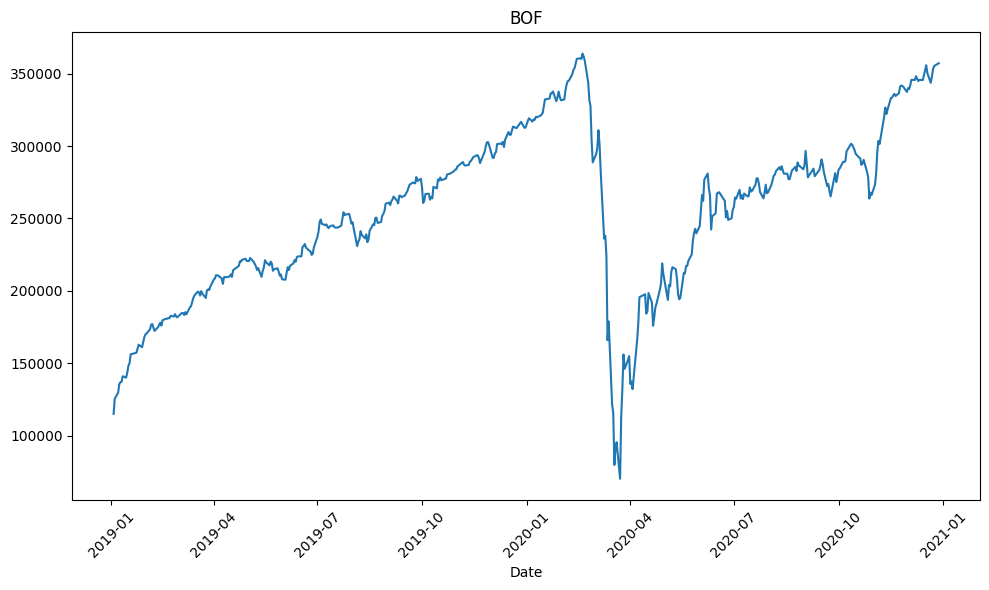

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(bof.index, bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("BOF")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

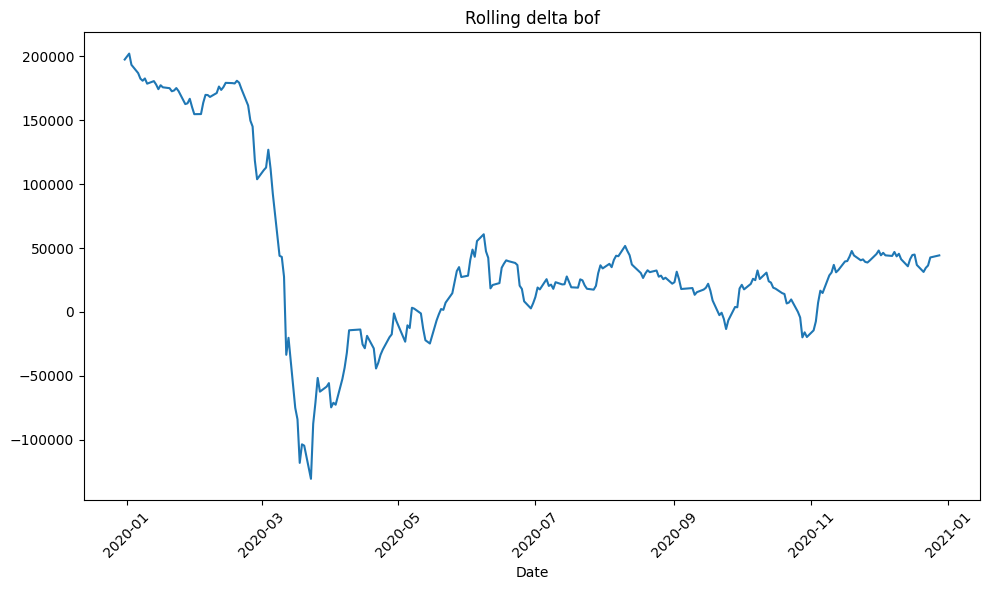

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(rolling_delta_bof.index, rolling_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("Rolling delta bof")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

# Case 2

Same, assuming constant BOF0

In [17]:
bof.loc["2019-12-31"]

np.float64(312804.51417605917)

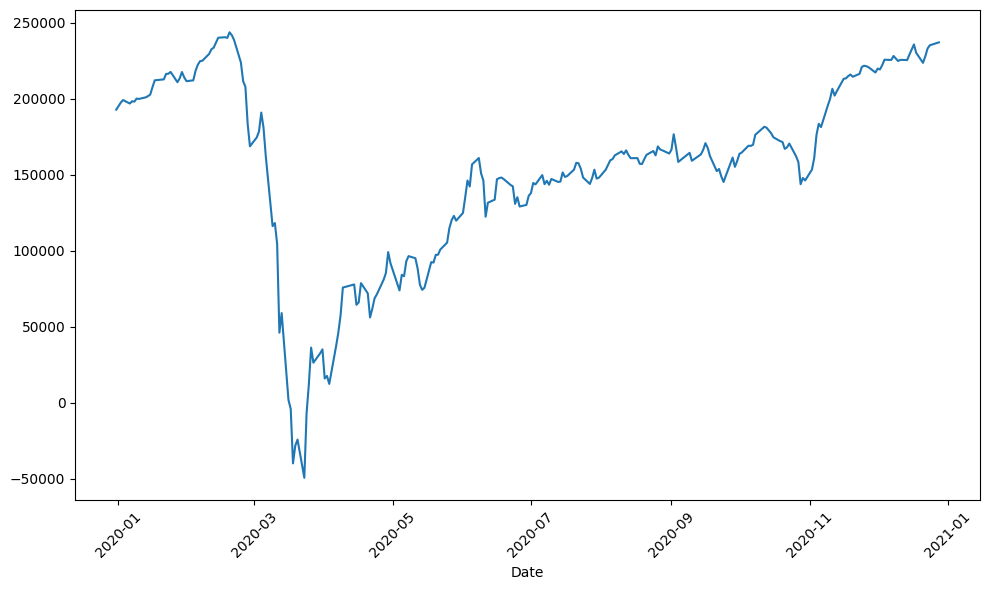

In [18]:
bof_case_ii = bof.loc["2019-12-31":]

delta_bof_case_ii = bof_case_ii - bof_0

plt.figure(figsize=(10, 6))
plt.plot(delta_bof_case_ii.index, delta_bof_case_ii.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

In [19]:
asset_names = list(returns_df.columns)

# scenarios_results is assumed to be a nested dictionary:
# { asset_name: { date: scenarios_array, ... }, ... }
# where scenarios_array has shape (n_simulations, window_size)
#
# We want to build a matrix for each date of shape (n_simulations, n_assets),
# where each column is the last value (i.e. cumulative return) from the corresponding asset’s scenarios.

# Get the list of dates for which we have generated scenarios.
# (Assuming the dates are the same across assets, here we take the dates from the first asset.)
all_dates = sorted(list(scenarios_results[asset_names[0]].keys()))

# Dictionary to store SCR for each date.
portfolio_scr_results = {}  # key: date, value: scr

for date in all_dates:
    gan_samples_cols = []
    for asset in asset_names:
        # Retrieve the scenarios for the asset at this date.
        asset_scenarios = scenarios_results[asset][date]  # expected shape: (n_simulations, window_size)
        # Use the last column to represent the cumulative return.
        asset_cum = np.prod(1 + asset_scenarios, axis=1) - 1
        gan_samples_cols.append(asset_cum.reshape(-1, 1))

    # Stack horizontally so that each column corresponds to one asset.
    gan_samples = np.hstack(gan_samples_cols)  # shape: (n_simulations, n_assets)
    
    # Create a portfolio with the aggregated GAN samples and the specified weights.

    bof_0_case_i = bof.iloc[bof.index.get_loc(date) - 252]

    portfolio = SimpleGANPortfolio(gan_samples, weights, bof0_casei=bof_0_case_i)
    _, scr = portfolio.calculate_distribution_and_scr(case=2)
    
    portfolio_scr_results[date] = scr
    print(f"Date {date}: SCR = {scr}")


Date 2019-12-31 00:00:00: SCR = 9862.822865344393
Date 2020-01-02 00:00:00: SCR = 15259.30343175624
Date 2020-01-03 00:00:00: SCR = -10452.72429727005
Date 2020-01-06 00:00:00: SCR = -9108.259638805448
Date 2020-01-07 00:00:00: SCR = 16751.65916212355
Date 2020-01-08 00:00:00: SCR = -18900.564546282683
Date 2020-01-09 00:00:00: SCR = 3574.2624593107394
Date 2020-01-10 00:00:00: SCR = 17018.319282251156
Date 2020-01-13 00:00:00: SCR = 5083.709485007698
Date 2020-01-14 00:00:00: SCR = 13143.187676925616
Date 2020-01-15 00:00:00: SCR = 14033.072642130259
Date 2020-01-16 00:00:00: SCR = 11376.84194224486
Date 2020-01-17 00:00:00: SCR = 11821.815379957488
Date 2020-01-20 00:00:00: SCR = 9648.180150489874
Date 2020-01-21 00:00:00: SCR = 22160.001836373387
Date 2020-01-22 00:00:00: SCR = 4134.514694510869
Date 2020-01-23 00:00:00: SCR = 14870.802523795455
Date 2020-01-24 00:00:00: SCR = 2445.8760570743516
Date 2020-01-27 00:00:00: SCR = 28030.15174492974
Date 2020-01-28 00:00:00: SCR = 3736.9

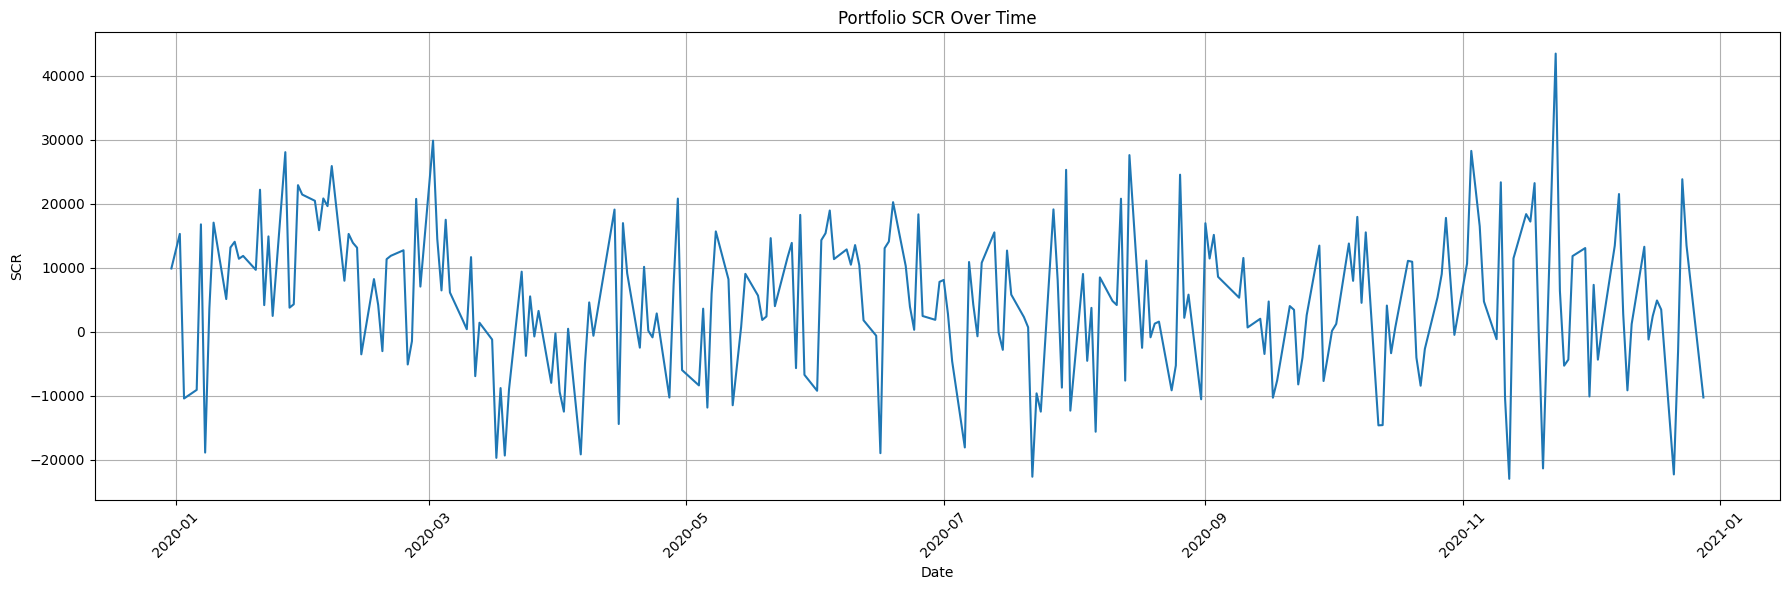

In [20]:
# Assume portfolio_scr_results is a dictionary with dates as keys and SCR values as values.
# First, sort the dates (this assumes the keys are either datetime objects or strings that sort chronologically)
sorted_dates = sorted(portfolio_scr_results.keys())
scr_values = [portfolio_scr_results[date] for date in sorted_dates]

plt.figure(figsize=(18, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

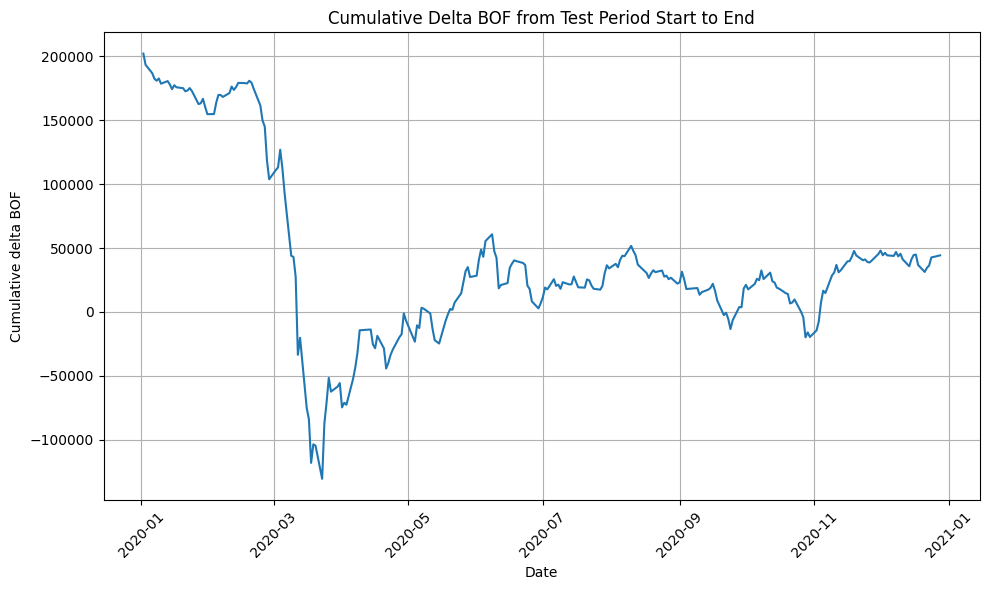

In [ ]:
# Suppose delta_bof is a pandas Series with a datetime index:
# For example:
# delta_bof = pd.Series(data_array, index=date_index)

# 1. Transform the daily delta_bof to a rolling 252-day basis.
#    Here, we compute the rolling sum over 252 days.


# 2. Determine the test period.
# Assume that returns_df contains historical data and test_returns_df contains the test period.
# Let test_start be the first date in test_returns_df.
test_start_date = test_returns_df.index[0]
test_end_date = test_returns_df.index[-1]

# Option A: If you want the rolling measure only for the test period,
# you can extract it from the rolling_delta_bof Series:
rolling_test = rolling_delta_bof.loc[test_start_date:test_end_date]

# Option B: If you instead want to calculate the cumulative delta_bof (running sum)
# over the test period (starting at test_start), do this:
delta_bof_test = delta_bof.loc[test_start_date:test_end_date]
cumulative_delta_bof_test = delta_bof_test.cumsum()

# 3. Plot the cumulative delta_bof over the test period.
plt.figure(figsize=(10, 6))
plt.plot(rolling_test.index, rolling_test.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Cumulative delta BOF")
plt.title("Cumulative Delta BOF from Test Period Start to End")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

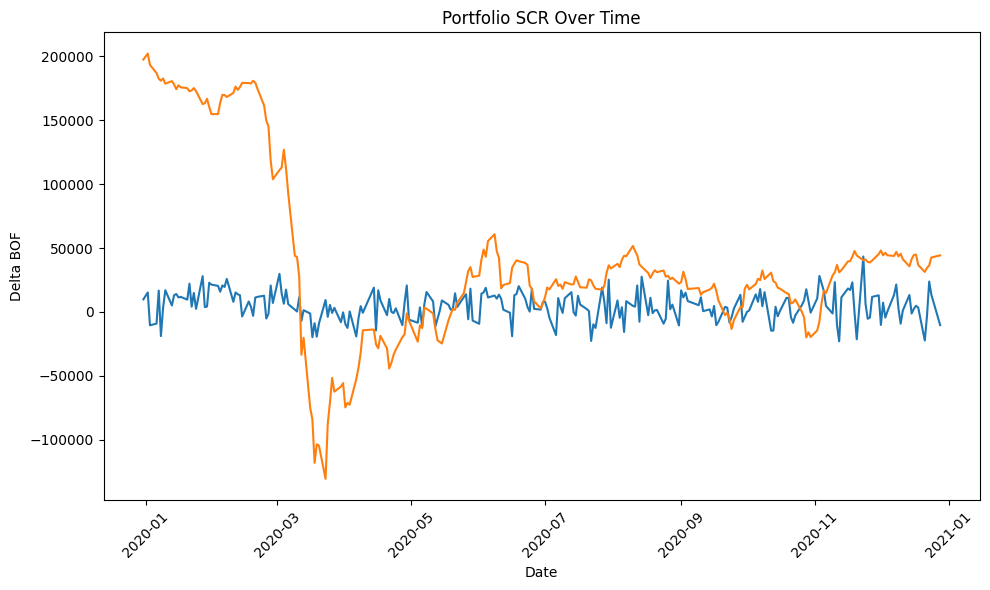

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.plot(rolling_delta_bof.index, rolling_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Delta BOF")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

## RESULTS

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_EONIA_final_scenarios.pt
Scaled = False


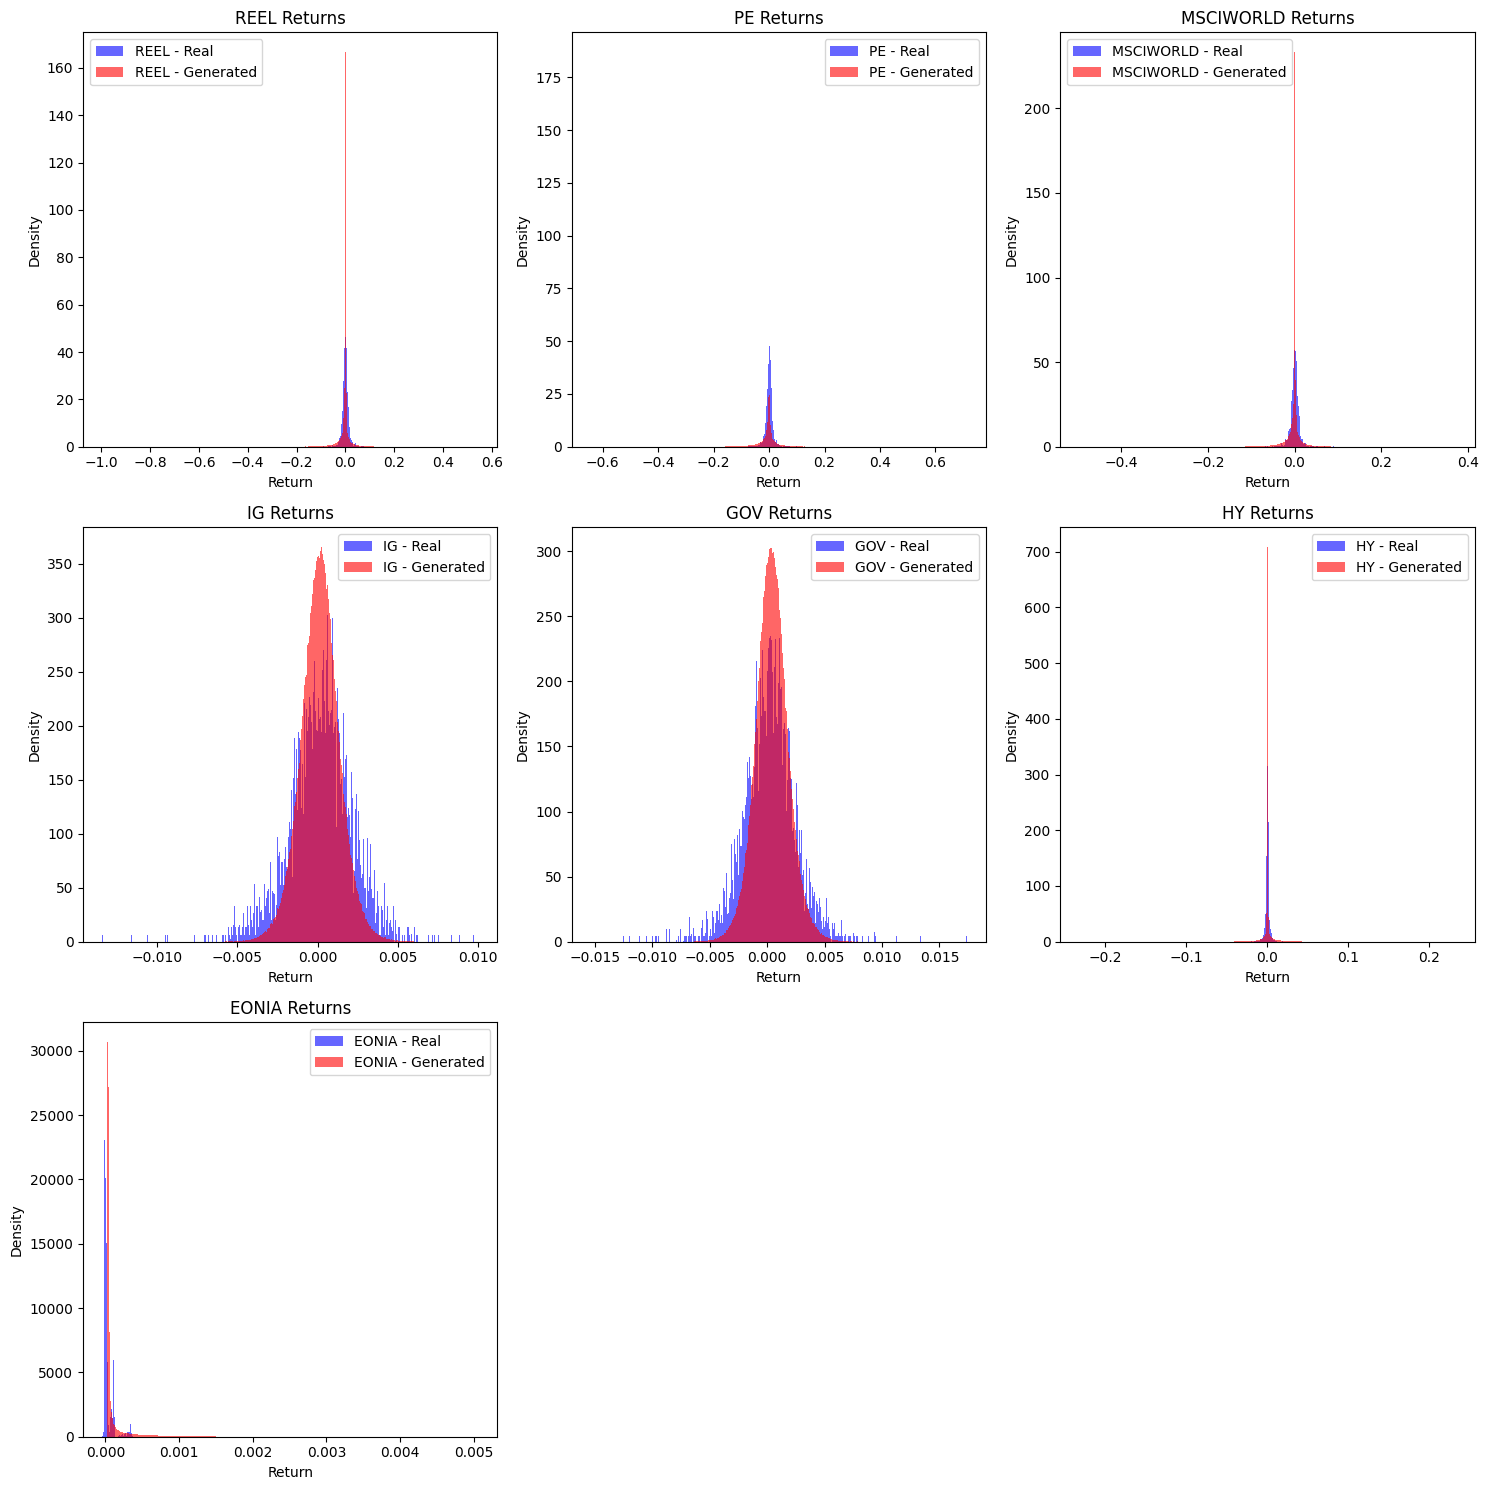


📊 Return Statistics Summary:
                Asset      Mean  Std Dev  Skewness  Kurtosis  99.5% VaR
          REEL - Real  0.000193 0.012916 -0.270455  4.969021  -0.051644
     REEL - Generated -0.003458 0.031310 -2.915666 47.968742  -0.163125
            PE - Real  0.000224 0.012736 -0.303648  6.380382  -0.052287
       PE - Generated -0.003231 0.034888 -1.154012 33.609531  -0.176356
     MSCIWORLD - Real  0.000283 0.009887 -0.226726  7.359869  -0.037021
MSCIWORLD - Generated -0.002518 0.021537 -2.087063 28.640760  -0.112612
            IG - Real  0.000182 0.002083 -0.458256  2.226597  -0.006788
       IG - Generated  0.000163 0.001229  0.016035  0.931641  -0.003327
           GOV - Real  0.000183 0.002449 -0.034370  4.018610  -0.008100
      GOV - Generated  0.000412 0.001460  0.075903  0.989935  -0.003696
            HY - Real  0.000279 0.003002 -1.860565 31.424899  -0.012798
       HY - Generated  0.000462 0.011216 -0.077706 45.425400  -0.052460
         EONIA - Real  0.000032 0.

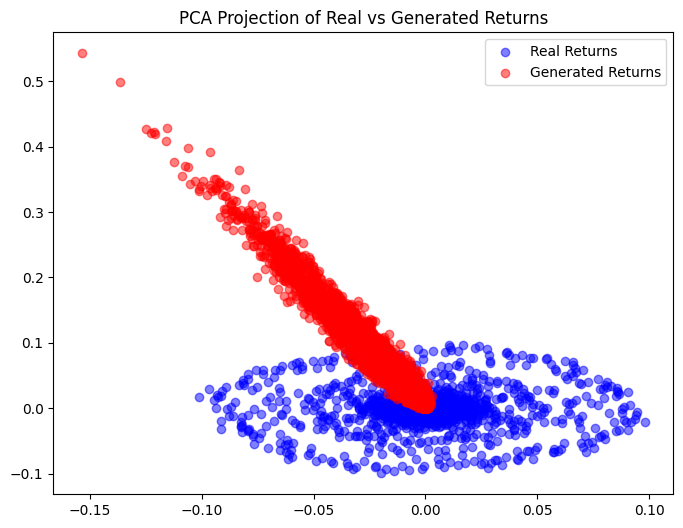

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt


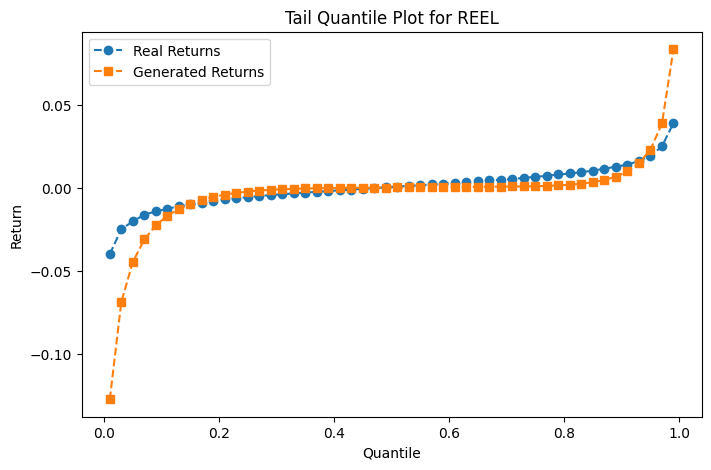


════════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: REEL  ║
════════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt

📊 Distance Summary for REEL:
Min Distance: 0.000000
Max Distance: 31.834894
Mean Distance: 0.010271
Median Distance: 0.000217
Standard Deviation: 0.212734


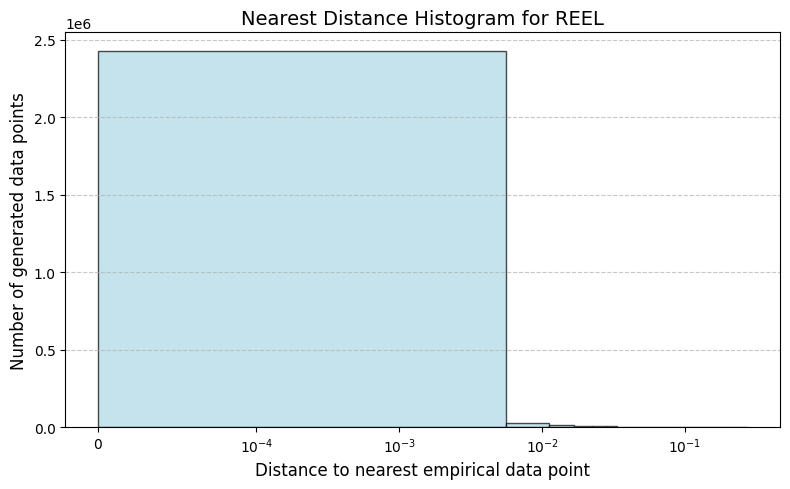


══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: REEL  ║
══════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt
📊 Wasserstein Distance for REEL: 0.008069


═════════════════════════
║  ANALYZING ASSET: PE  ║
═════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt
Variance of Real Data: 0.000162
Variance of Generated Data: 0.000972
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.268750
Mean Pairwise Distance (Generated): 0.421784
✅ Generated samples are reasonably diverse


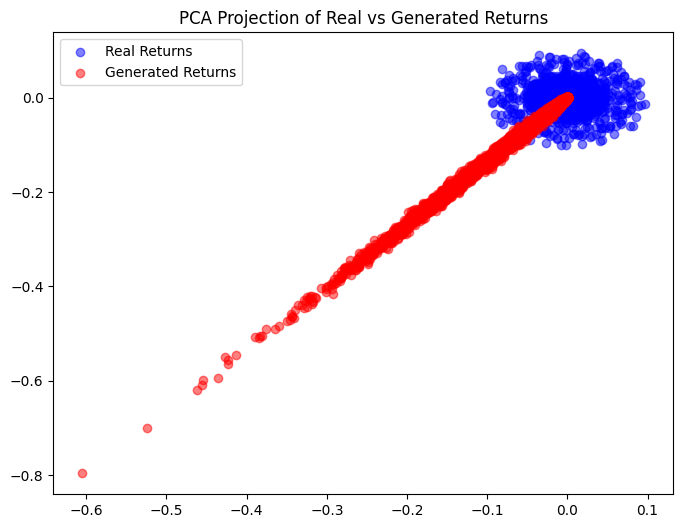

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt


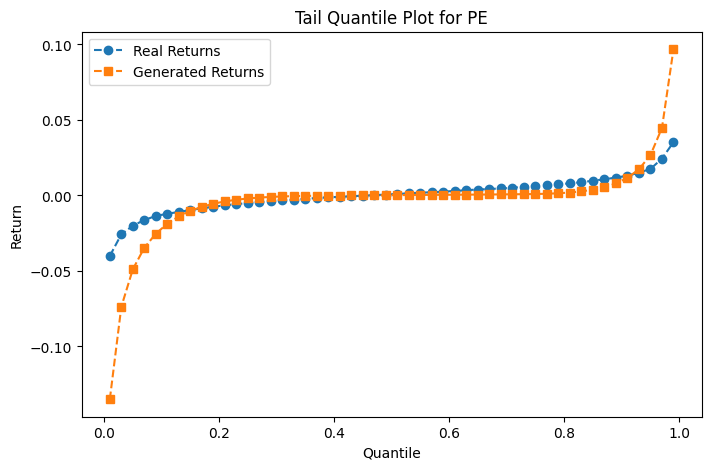


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: PE  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt

📊 Distance Summary for PE:
Min Distance: 0.000000
Max Distance: 23.948254
Mean Distance: 0.010711
Median Distance: 0.000180
Standard Deviation: 0.203668


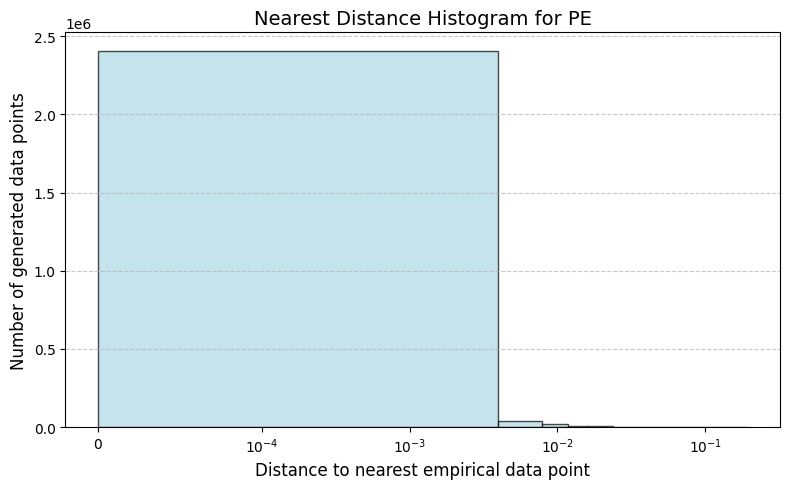


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: PE  ║
════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt
📊 Wasserstein Distance for PE: 0.009133


════════════════════════════════
║  ANALYZING ASSET: MSCIWORLD  ║
════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt
Variance of Real Data: 0.000098
Variance of Generated Data: 0.000330
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.211255
Mean Pairwise Distance (Generated): 0.263951
✅ Generated samples are reasonably diverse


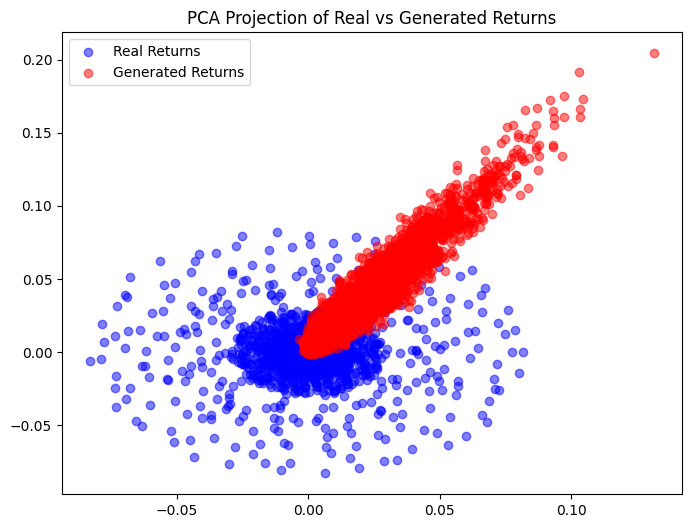

Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt


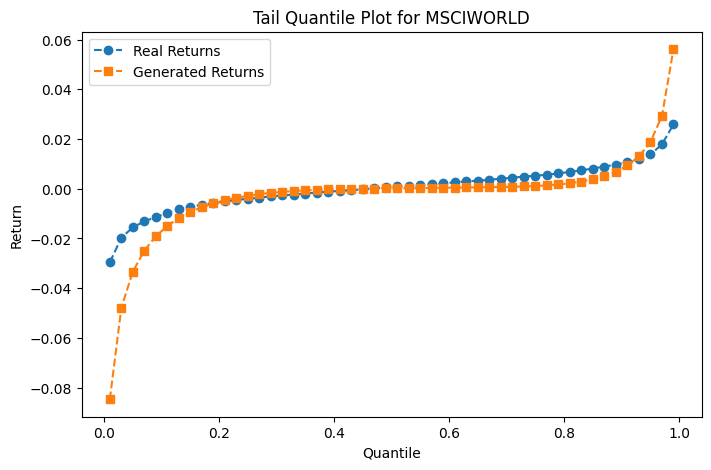


═════════════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: MSCIWORLD  ║
═════════════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt

📊 Distance Summary for MSCIWORLD:
Min Distance: 0.000000
Max Distance: 16.509566
Mean Distance: 0.006277
Median Distance: 0.000211
Standard Deviation: 0.119449


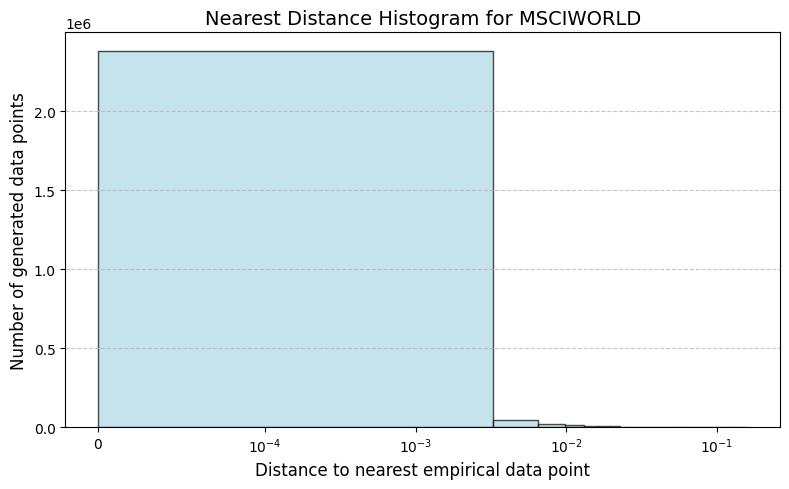


═══════════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: MSCIWORLD  ║
═══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt
📊 Wasserstein Distance for MSCIWORLD: 0.005503


═════════════════════════
║  ANALYZING ASSET: IG  ║
═════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt
Variance of Real Data: 0.000004
Variance of Generated Data: 0.000001
⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data
Mean Pairwise Distance (Real): 0.046002
Mean Pairwise Distance (Generated): 0.023266
✅ Generated samples are reasonably diverse


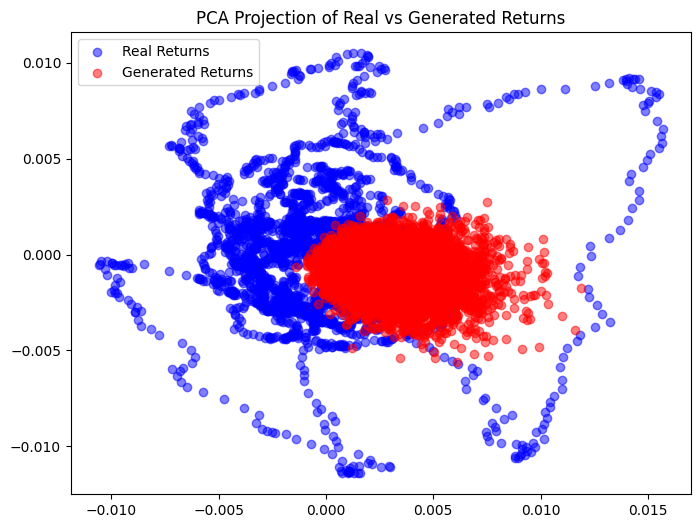

Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt


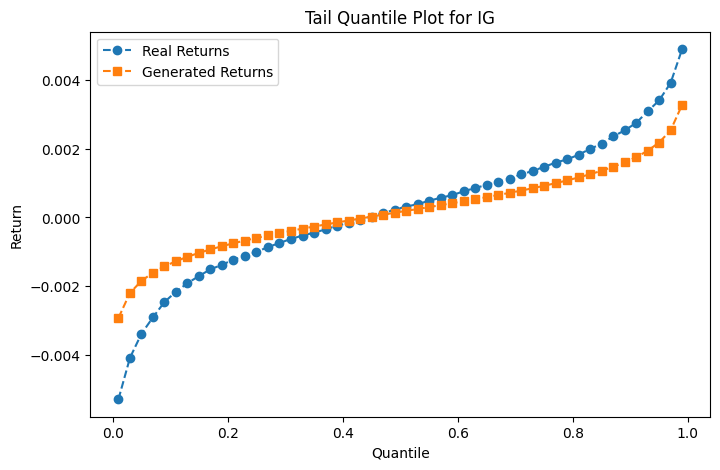


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: IG  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt

📊 Distance Summary for IG:
Min Distance: 0.000000
Max Distance: 3.420969
Mean Distance: 0.001470
Median Distance: 0.000369
Standard Deviation: 0.014097


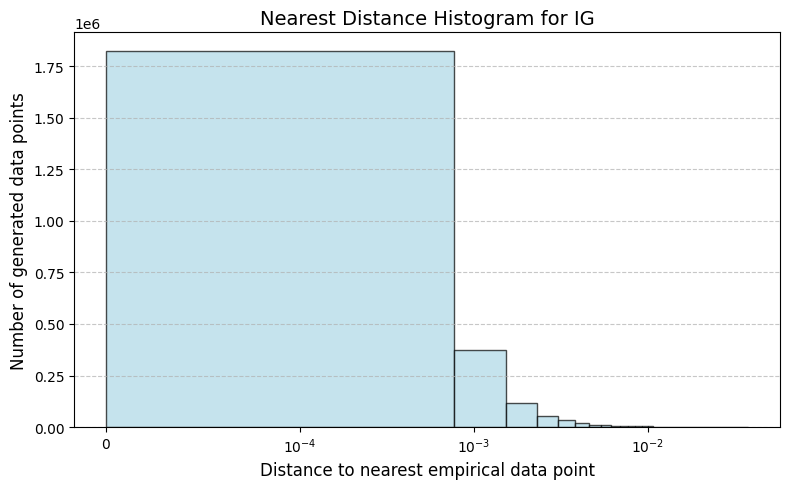


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: IG  ║
════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt
📊 Wasserstein Distance for IG: 0.000625


══════════════════════════
║  ANALYZING ASSET: GOV  ║
══════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt
Variance of Real Data: 0.000006
Variance of Generated Data: 0.000002
⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data
Mean Pairwise Distance (Real): 0.054322
Mean Pairwise Distance (Generated): 0.027151
⚠️ Warning: Potential Mode Collapse - Samples are too similar


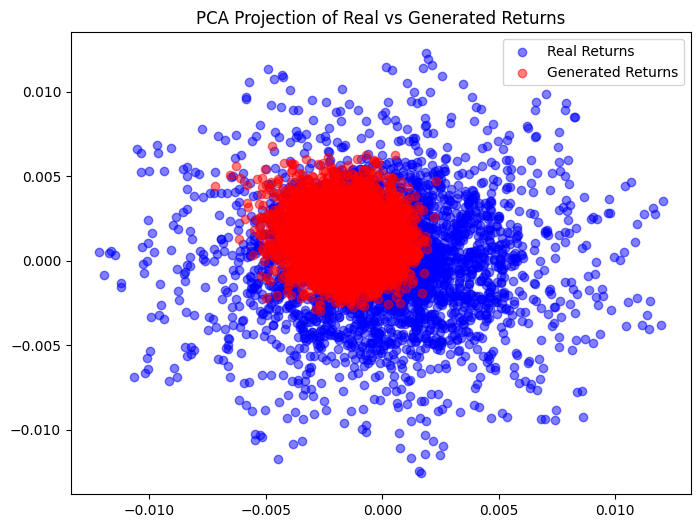

Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt


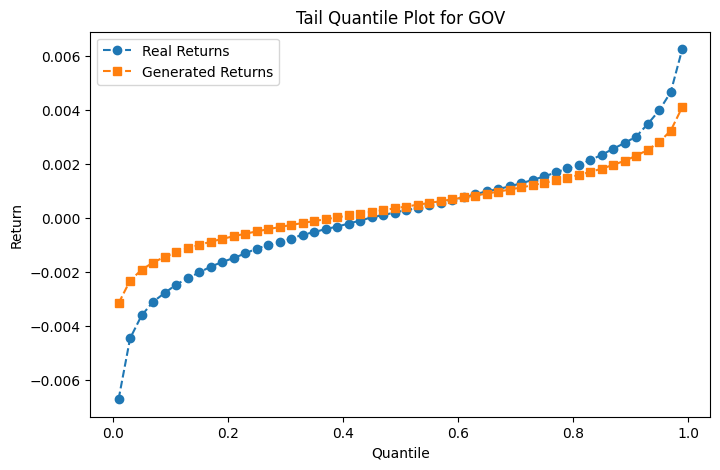


═══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: GOV  ║
═══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt

📊 Distance Summary for GOV:
Min Distance: 0.000000
Max Distance: 2.558961
Mean Distance: 0.001287
Median Distance: 0.000358
Standard Deviation: 0.006974


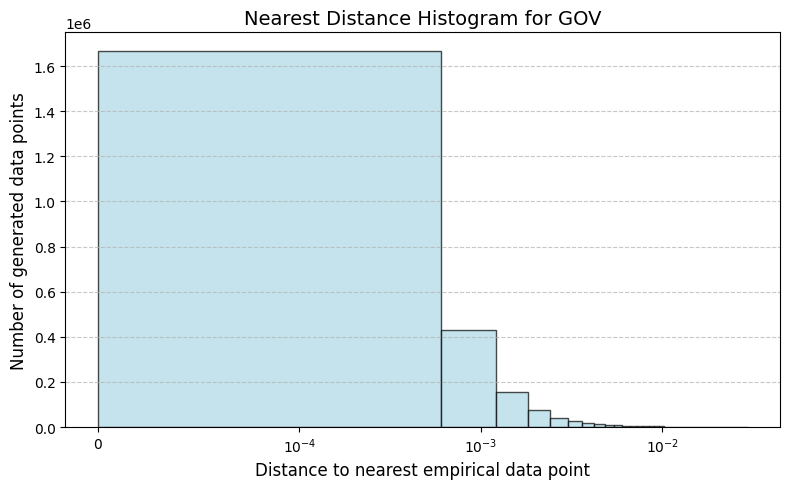


═════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: GOV  ║
═════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt
📊 Wasserstein Distance for GOV: 0.000676


═════════════════════════
║  ANALYZING ASSET: HY  ║
═════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt
Variance of Real Data: 0.000009
Variance of Generated Data: 0.000097
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.060213
Mean Pairwise Distance (Generated): 0.117057
✅ Generated samples are reasonably diverse


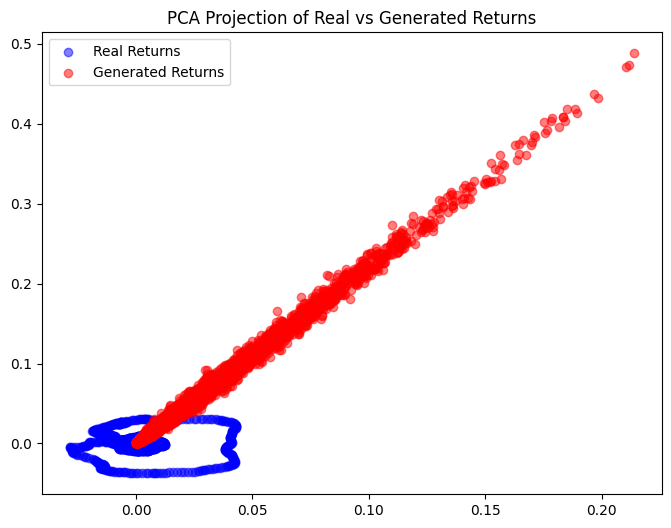

Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt


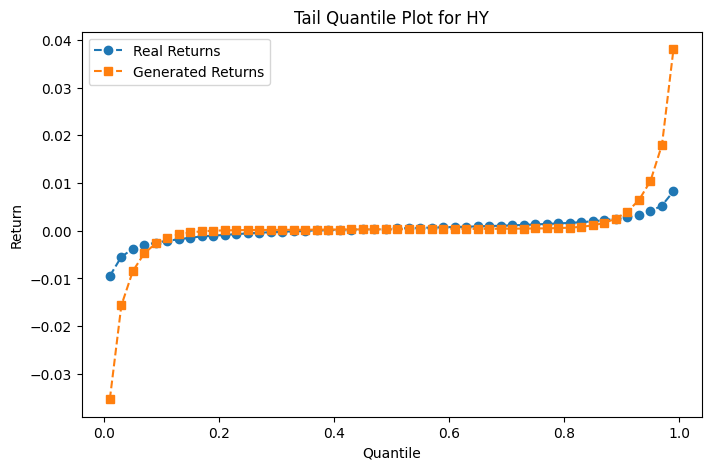


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: HY  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt

📊 Distance Summary for HY:
Min Distance: 0.000000
Max Distance: 15.372253
Mean Distance: 0.006363
Median Distance: 0.000120
Standard Deviation: 0.112773


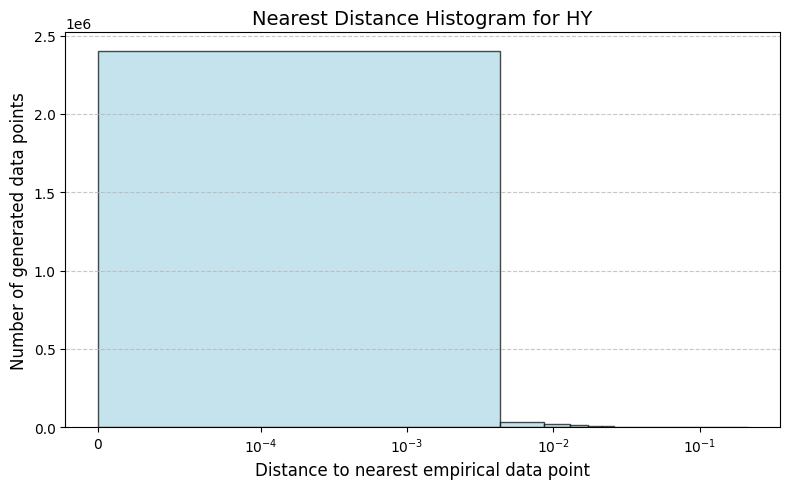


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: HY  ║
════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt
📊 Wasserstein Distance for HY: 0.002749


════════════════════════════
║  ANALYZING ASSET: EONIA  ║
════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_EONIA_final_scenarios.pt
Variance of Real Data: 0.000000
Variance of Generated Data: 0.000000
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.001171
Mean Pairwise Distance (Generated): 0.002685
✅ Generated samples are reasonably diverse


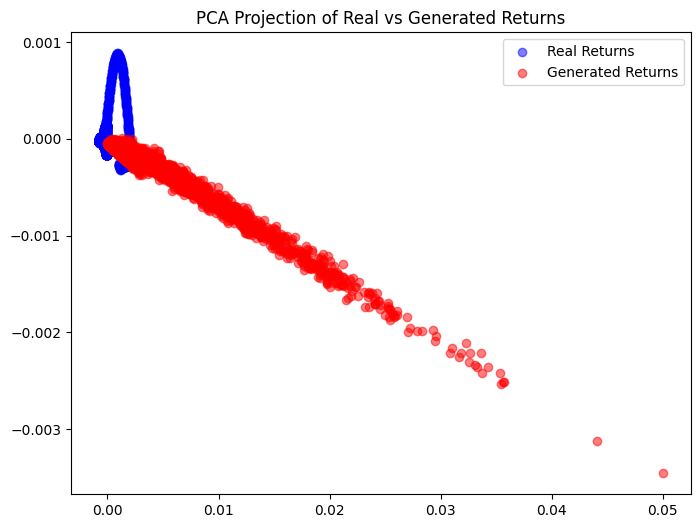


═══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: EONIA  ║
═══════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_EONIA_final_scenarios.pt
📊 Wasserstein Distance for EONIA: 0.000102



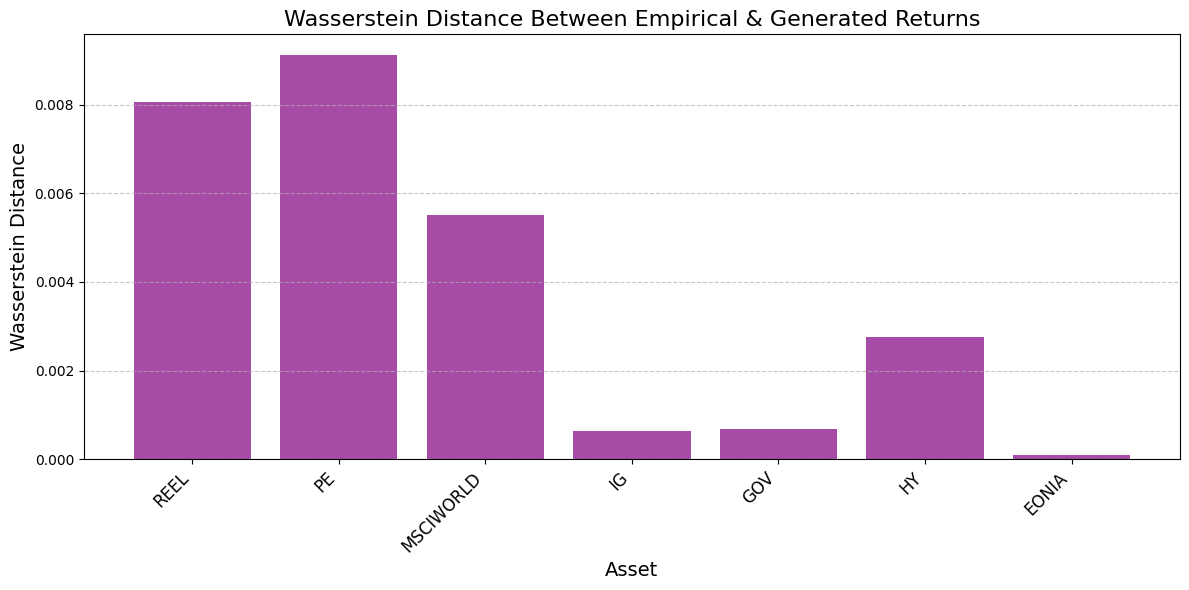

In [23]:
extensive_plotting(scaled=False, returns_df=returns_df, test=False, quarterly=False)

# ----------------------------------------------------------

In [ ]:
from utilities.load_generated_quarters import load_all_generated_quarters

In [ ]:
for asset_name in returns_df.columns:
    # Create a new function that loads all fucking quarter for a fucking asset
    generated_returns = load_all_generated_quarters(asset_name, quarterly=True, test=True)

    failures, var_thresholds = backtest_var_single_asset(test_returns_df[asset_name], generated_returns, asset_name, quarterly=True)

    perform_var_backtesting_tests(failures=failures, returns=test_returns_df[asset_name], var_forecast=var_thresholds, asset_name=asset_name, generated_returns=generated_returns)


    perform_distribution_tests(generated_returns=generated_returns[0], empirical_returns_rolling=create_rolling_empirical(returns_df[asset_name]), asset_name = asset_name)


FileNotFoundError: [Errno 2] No such file or directory: 'generated_CGAN_output_test\\q0\\generated_returns_REEL_q0.pt'